In [1]:
import os
import src

In [2]:
sheet = src.Sheet('samples/paraclis.pdf')

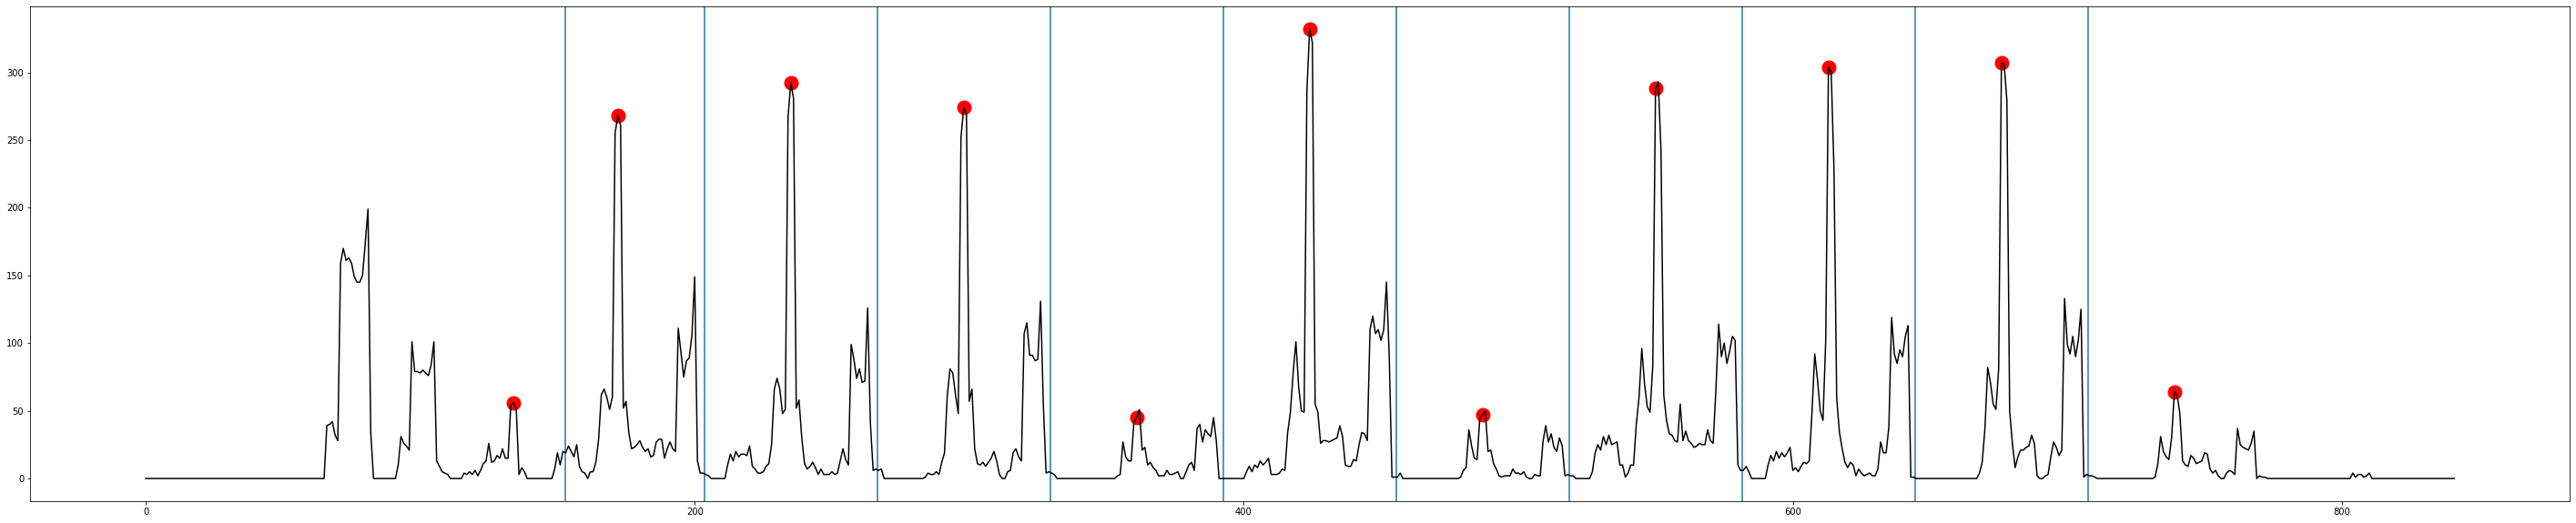

In [3]:
sheet[4].plot_raw_horizontal_projection()

next=y = 124
prev=y = 63
next=y = 187
prev=y = 124
next=y = 250
prev=y = 187
next=y = 313
prev=y = 250
next=y = 376
prev=y = 313
next=y = 494
prev=y = 376
next=y = 557
prev=y = 494
next=y = 621
prev=y = 557
next=y = 684
prev=y = 621
next=y = 747
prev=y = 684


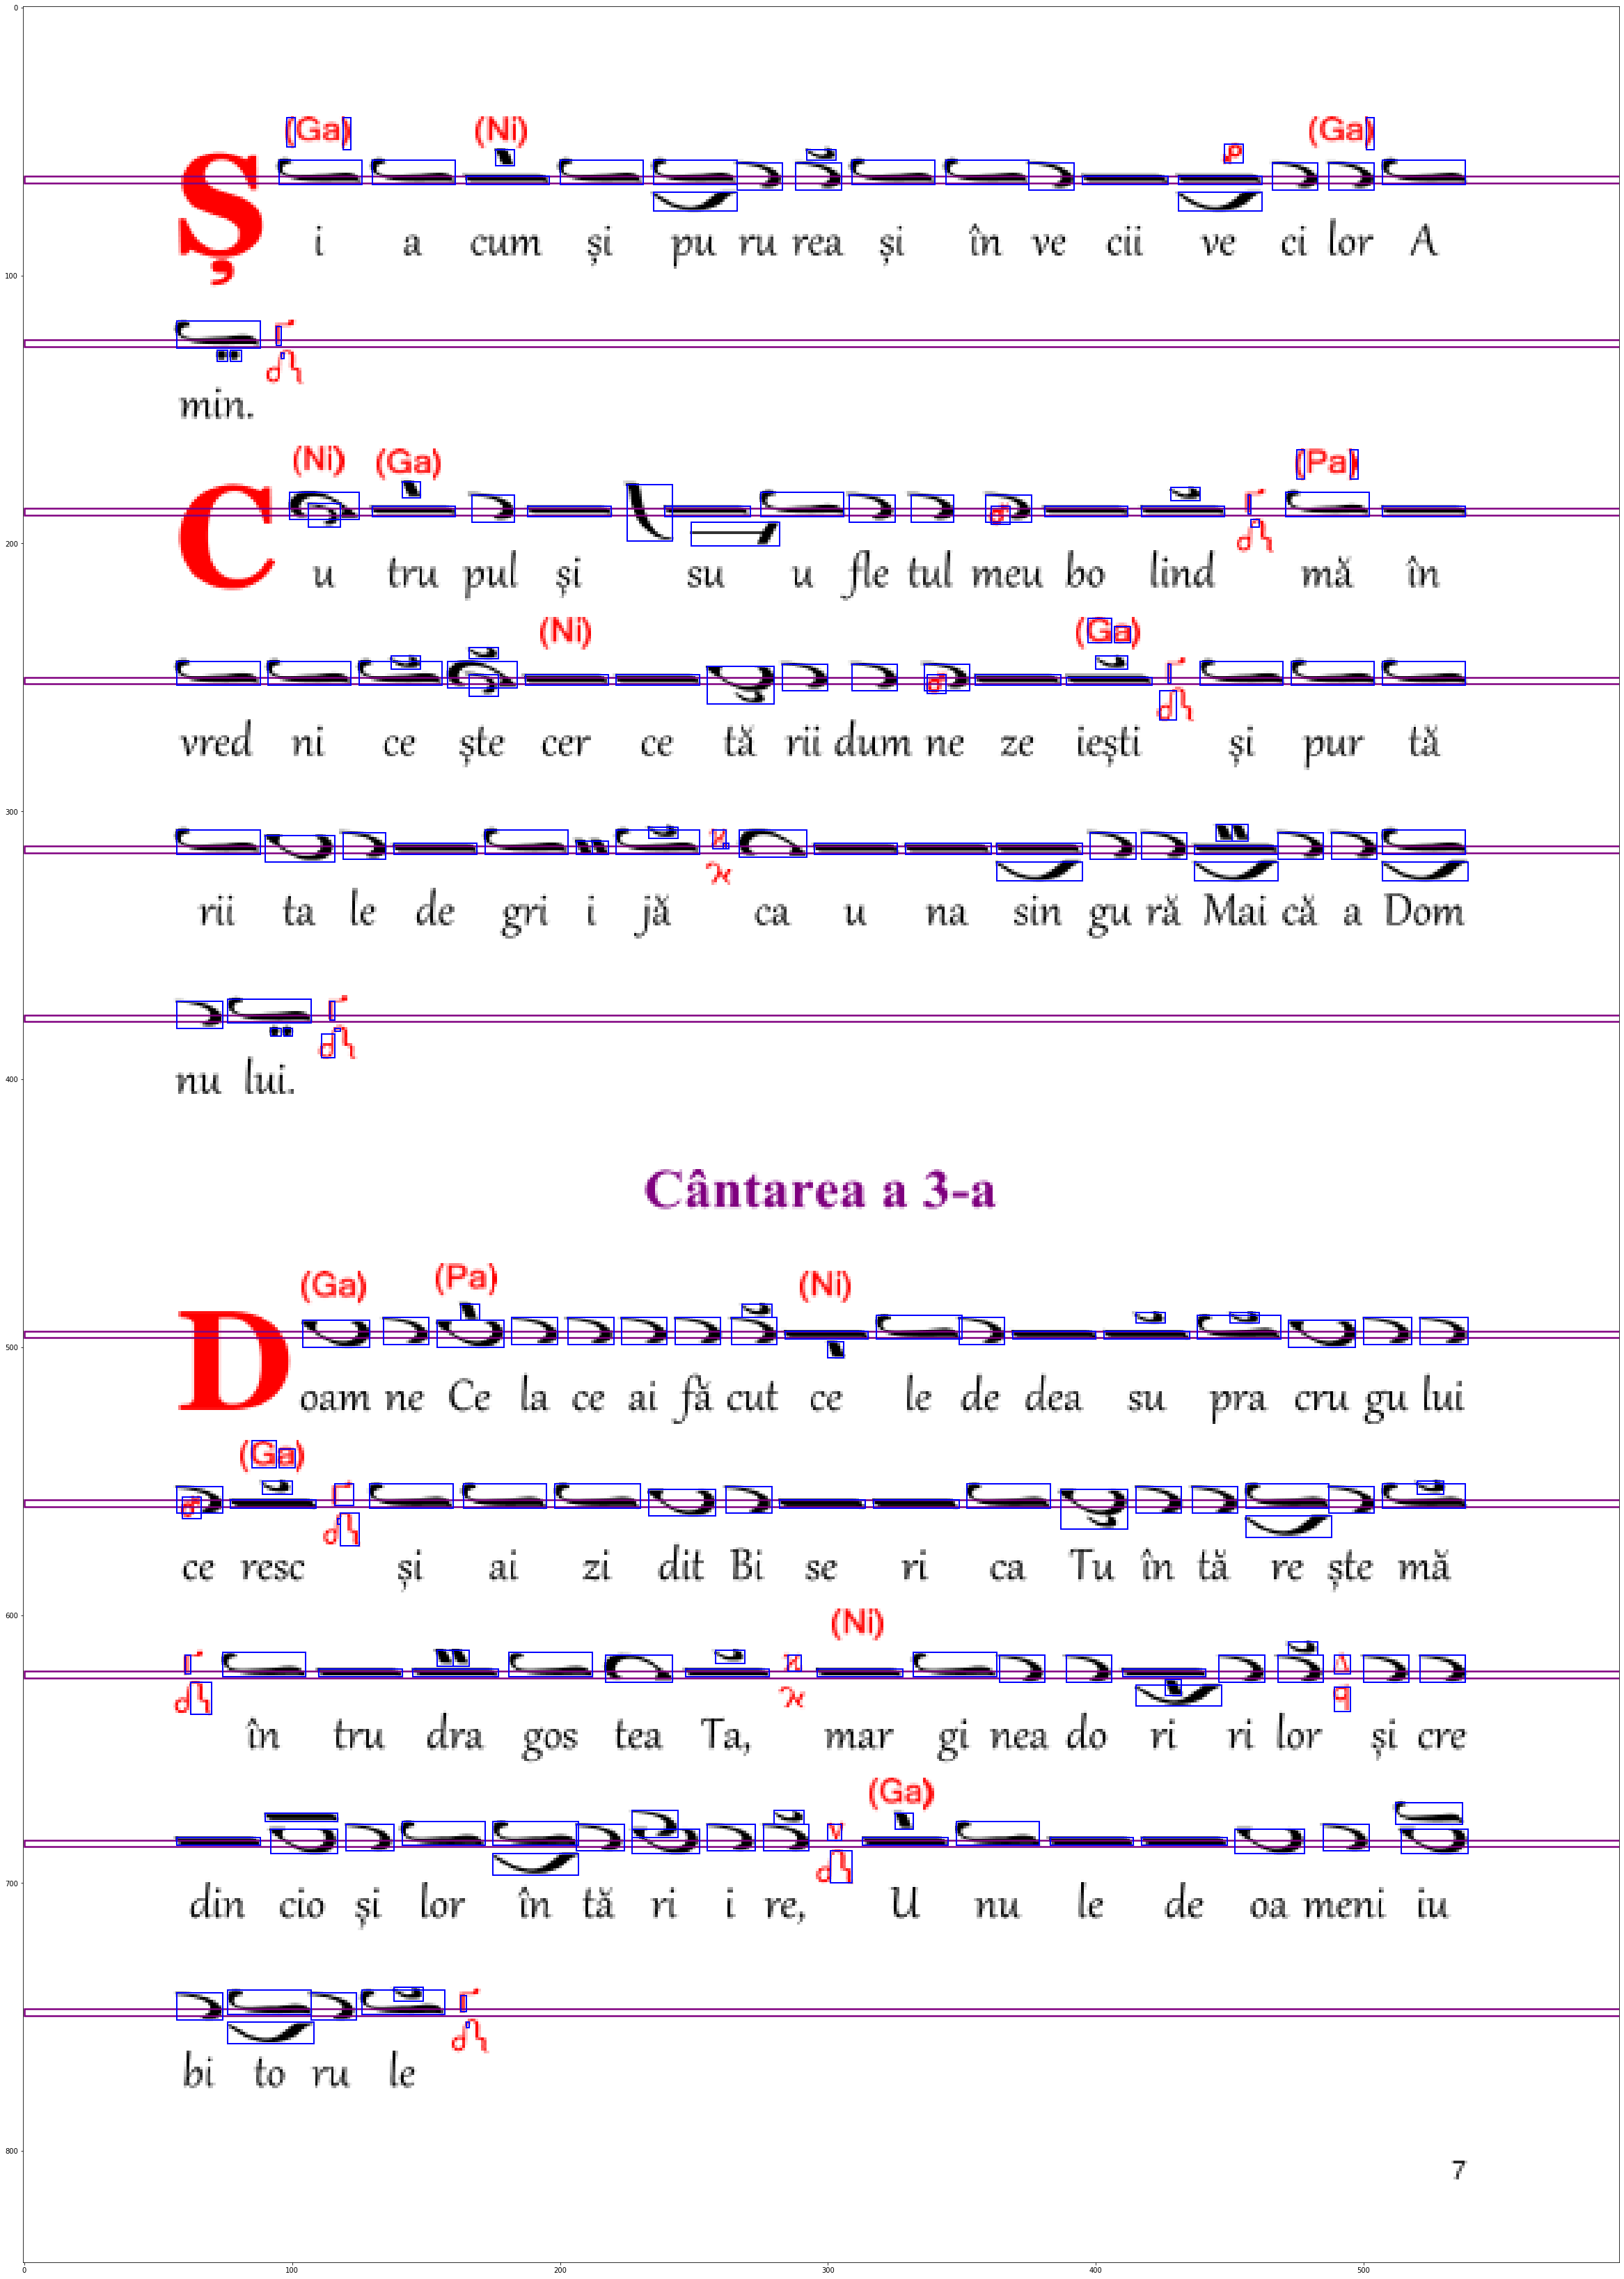

In [4]:
sheet[6].plot_mapped_neumes()

32


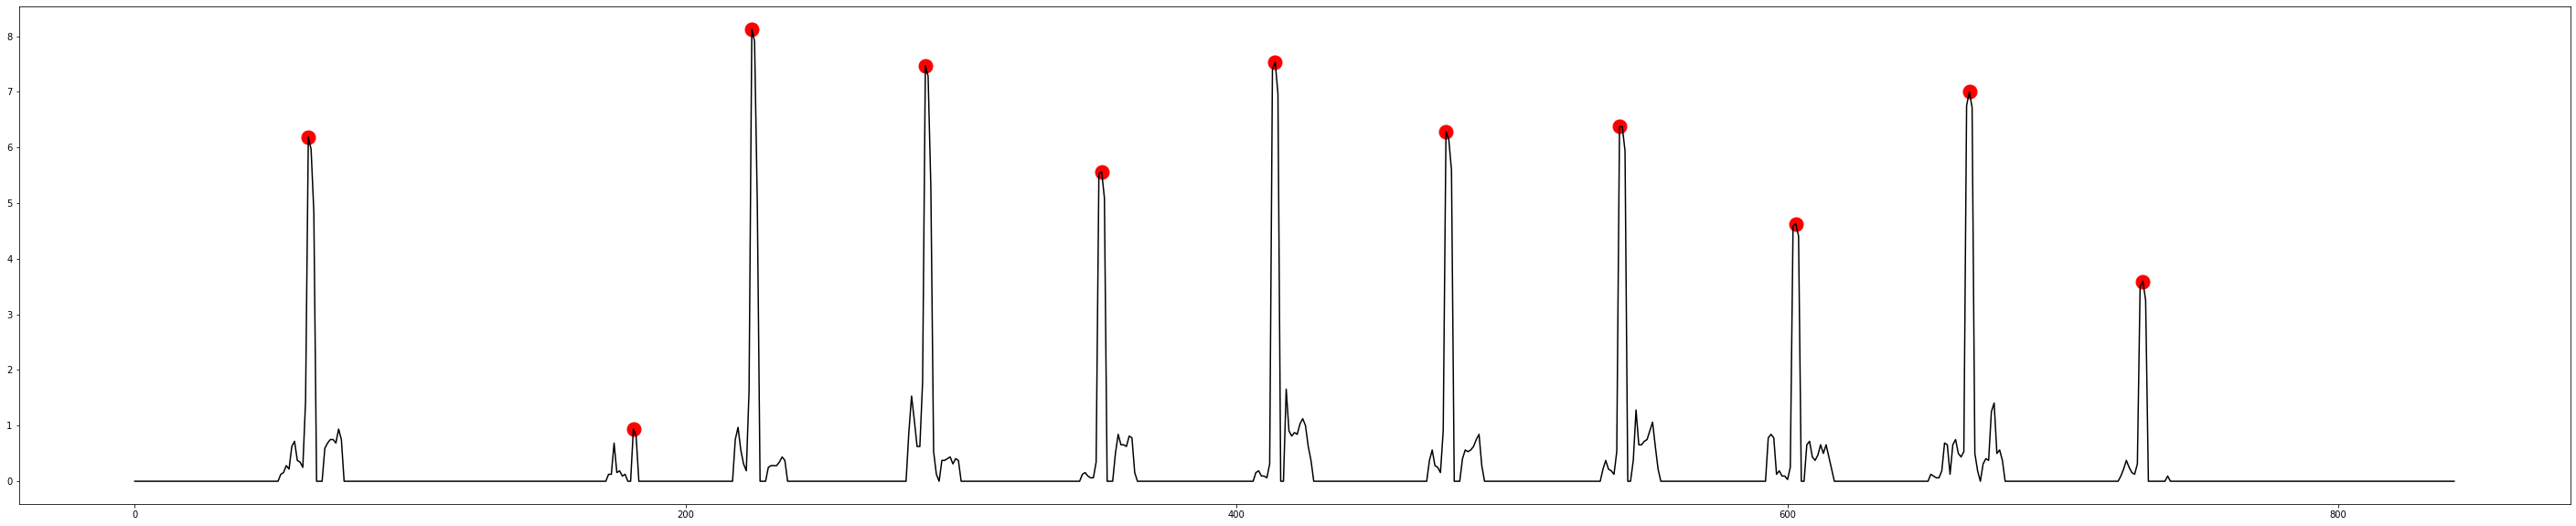

In [5]:
print(sheet.oligon_width)
sheet[24].plot_horizontal_projection()

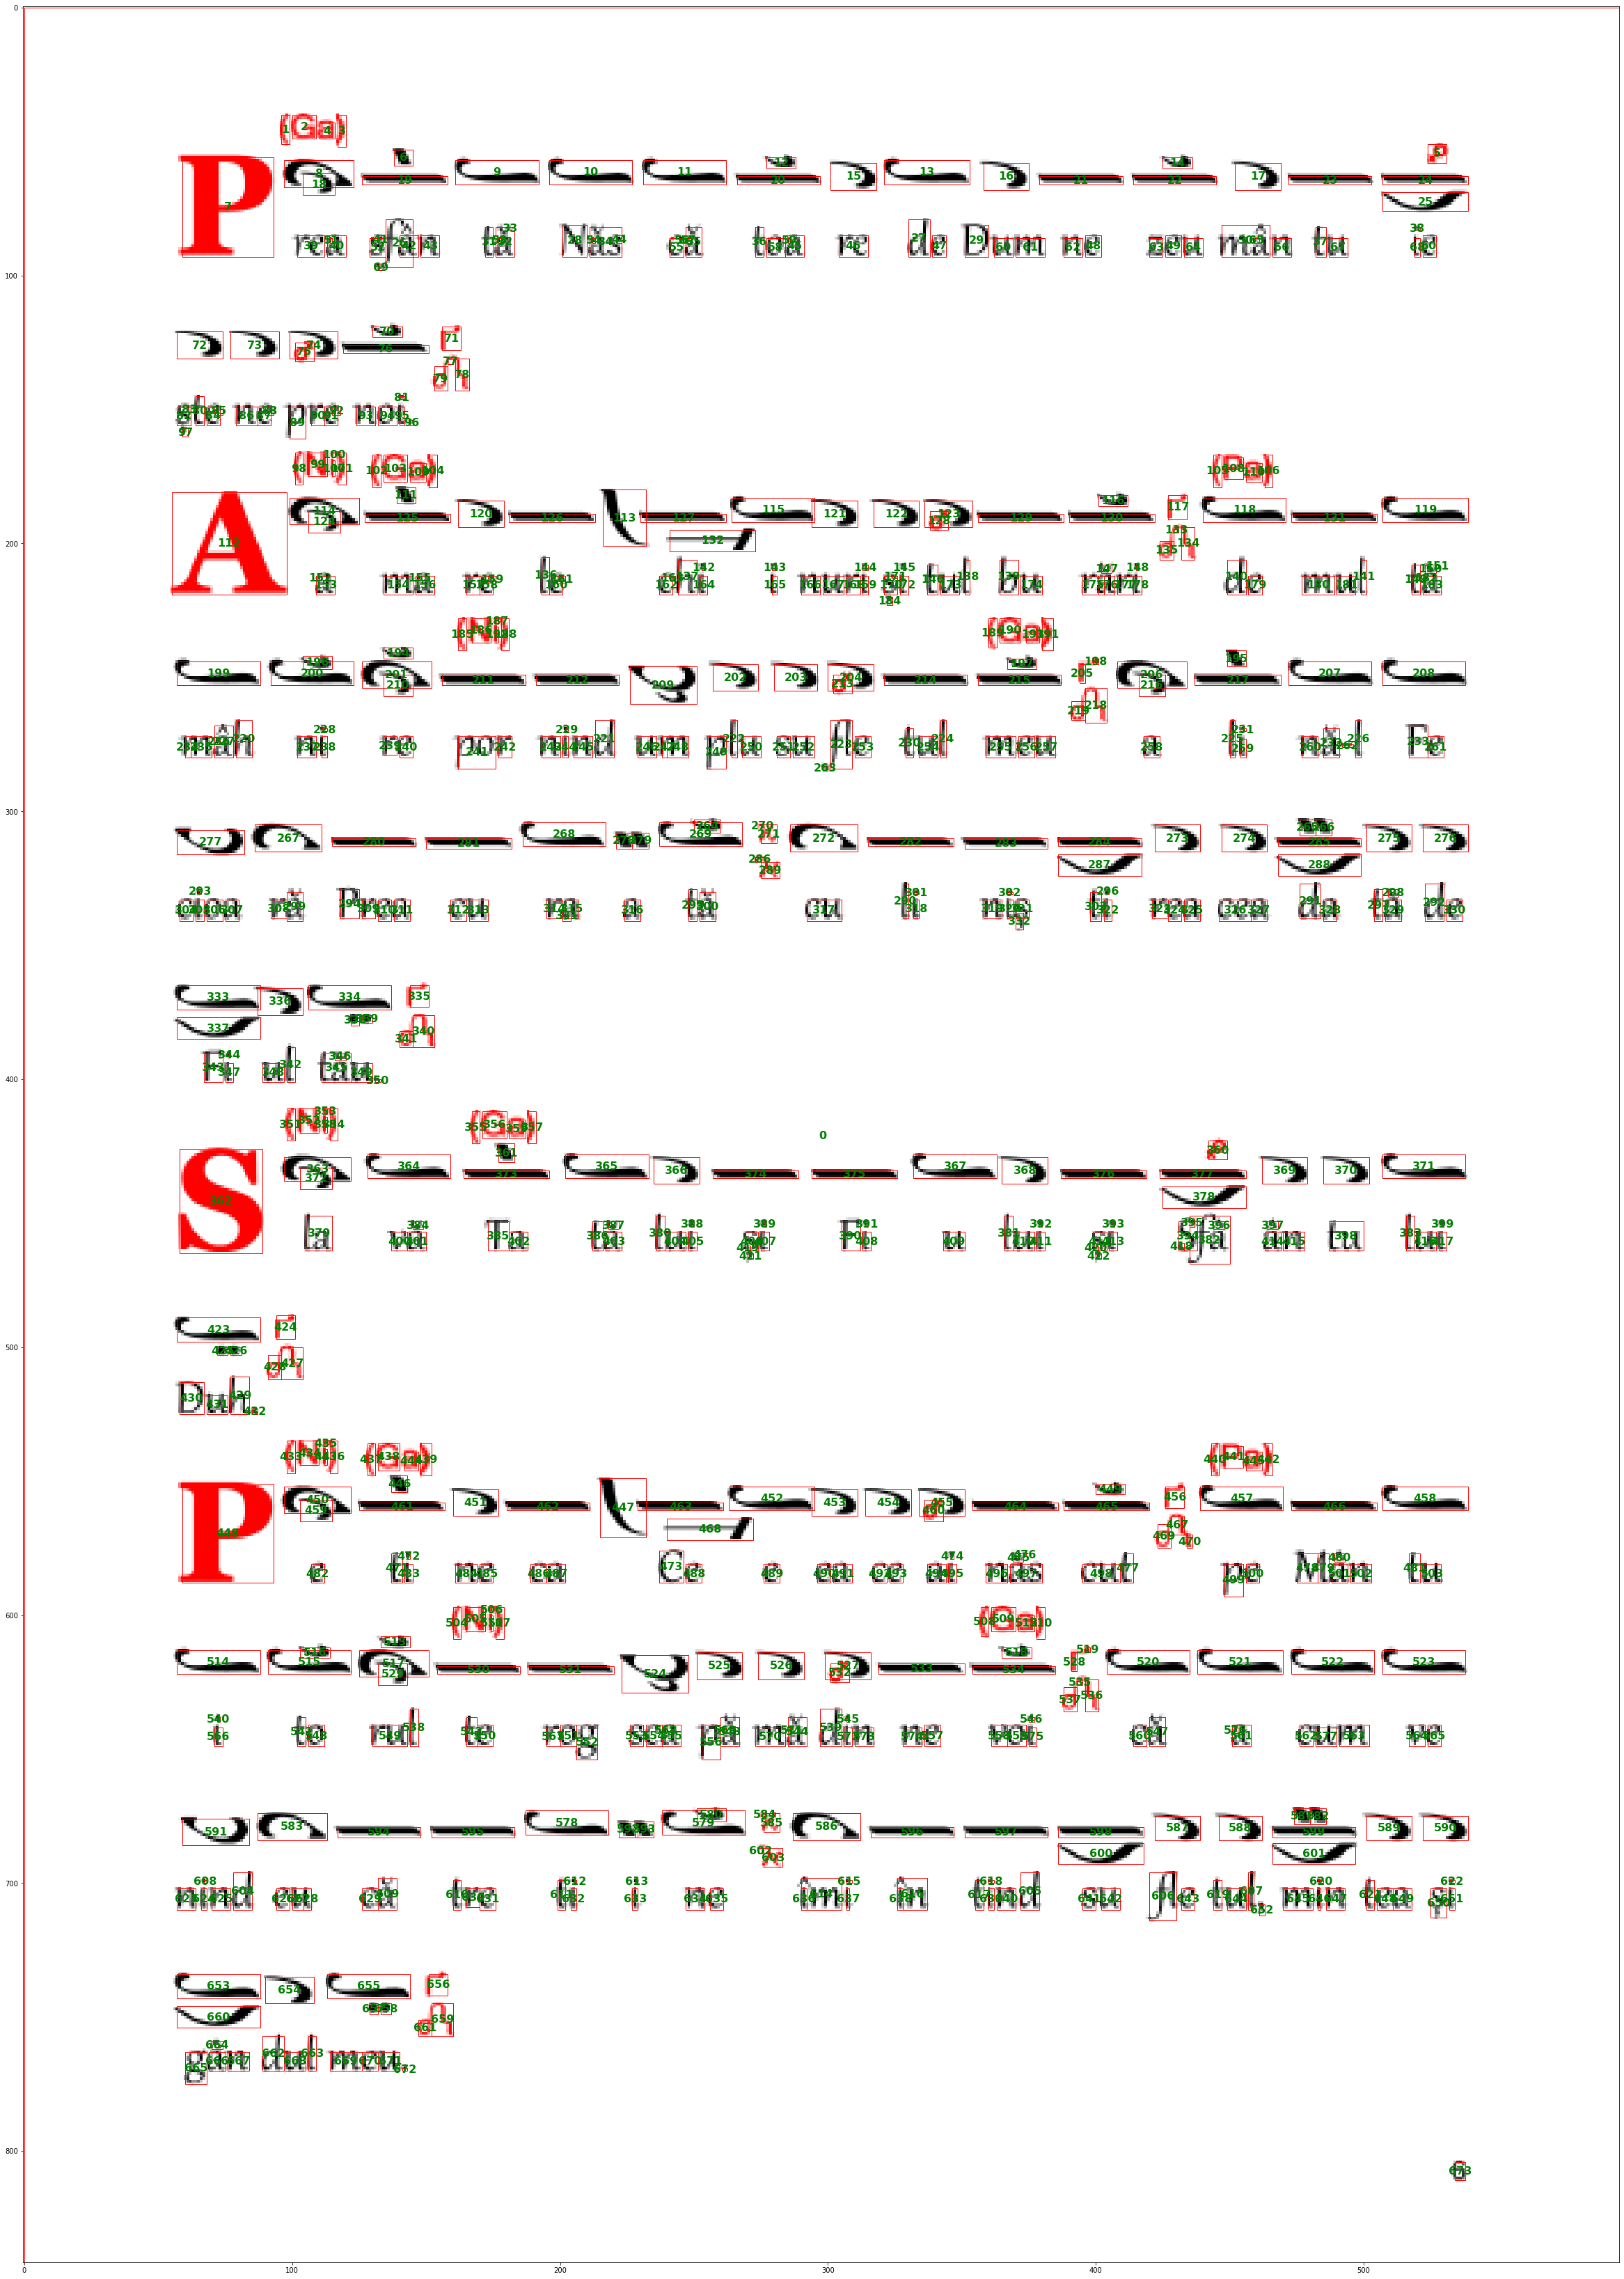

In [6]:
sheet[5].plot_ccs(ratio=0)